# BCI EEG - P300 On-Screen Menu Selection
Data collected bu Ulrich Hoffman's research group at EPFL accompanying their 2008 publication in the Journal of Neuroscience Methods. Subjects were asked to concentrate on one of six different objects on a screen as they flashed. When the target image flashed the EEG data exhibts a P300 response. We must decode which of the 6 items was the target image. 
Try to keep very few EEG channels to maintain a less intrusive and moresimple interface.
The BCI should be able to differentiate consistently across multiple different items and even different people, that way it can be programmed for the "average" person, instead of having to train it per user.


## Part A - Intro to EEG processing and Extracting
### Question 1

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pylab as pl
import pandas as pd
import datetime
from scipy import signal
import glob
import os
import sys
from math import *

In [2]:
path =['subject6/session1/','subject6/session2/','subject6/session3/','subject6/session4/']
mats = []
for session in path:
    for file in os.listdir(session):
        mats.append(glob.glob(session+file))

In [3]:
# NOTE: analyze events matrix
# --- Events to Samples and Unpack Stamp functions--- (given)
def unpackStamp(x):
    y = np.int32(x[0])
    mo = np.int32(x[1])
    d = np.int32(x[2])
    h = np.int32(x[3])
    mi = np.int32(x[4])
    s = x[5]
    s_new = np.int32(np.floor(s))
    micros = np.int32((s - s_new) * 1e6)
    unpacked = datetime.datetime(y, mo, d, h, mi, s_new, micros)
    return unpacked

def events2samps(events, fs):
    firsteve_time = 0.4
    Nevents = events.shape[0]
    evesamps = np.zeros(Nevents)
    for k in range(Nevents):
        td =  unpackStamp(events[k, :]) - unpackStamp(events[0, :])
        evesamps[k] = np.int32(np.round(td.total_seconds()*fs + firsteve_time*fs + 1))
    
    return evesamps

In [4]:
def singletrial(file):
    data = file['data'] 
    stim = file['stimuli']
    target = file['target']*np.ones(stim.shape) #make sure every trial is associated to a target value for later use
    t_count = file['targets_counted']
    events = file['events']
    fs = 2048
    # Mastoid channels are 33 and 34
    chan_33 = data[32,:]
    chan_34 = data[33,:]
    # Average between mastoid channels 
    ref = 0.5 * chan_33 + 0.5 * chan_34
    # Subtract the average of mastoids from all channels 
    r_data = data - ref.T

    #Bandpass the data between 1 and 12 Hz using a relatively sharp FIR filter (0.5Hz transition band)
    N = int(fs/0.5) #length of bandpass
    f_high = 1
    f_low = 12
    h = signal.firwin(N, [f_high, f_low], pass_zero='bandpass', fs=fs) #impulse bandpass

    #Apply filter to data
    data_filt = signal.filtfilt(h, 1, r_data)
    
##__ ANSWER TO QUESTION:
##__ The filtering should be done before the segmentation due to the amount of processing time and power it requires,
##__ especially since we will be filtering back and forth since we don't want any delay in our signal

    #Turn events into samps
    samps = events2samps(events,fs)

    # # Extract single trial response (AKA epochs) for all non-target amd target events by extracting the segment fromtiem 0 to time 100ms following each event.
    # # Make max and min of time range into sample units
    tmin = int(0.000 * fs)
    tmax = int(1.000 * fs)

    # Create empty epochs matrix
    epochs = np.zeros((data_filt.shape[0]-2,samps.size,(tmin+tmax)))
    cols = np.zeros((samps.size,(tmin+tmax)))

    # Loop through each sample values of flash references in samps and the response of all 32 electrodes in data_filt 
    for i in range(data_filt.shape[0]-2):
        for n  in  range(samps.size): 
            cols[n,:] = data_filt[i,int(samps[n]):(int(samps[n]) + int(tmax))]
            epochs[i,:] = cols
    return epochs,target,stim,t_count

### The standard recommendation made by EEG practitioners is to do filtering before the next step (segmenting to get “epochs”). Comment on why that may be so.
The filtering should be done before the segmentation due to the amount of processing time and power it require. Especially since we will be filtering back and forth since we don't want any delay in our signal.

In [5]:
def baseline(epochs):
    # Subtract baseline DC value from each trial. 
    # Note: Baseline here is the average of the first 100 ms 
    # 100ms in Sample Units
    fs=2048
    first100 = int(np.round(0.100 * fs))
    baseline = np.zeros((epochs.shape[0],epochs.shape[1]))
    for f in range(epochs.shape[1]):
        baseline[:,f] = np.mean(epochs[:,f,0:first100])
        epochs[:,f,:] = epochs[:,f,:] - baseline[:,f][:,np.newaxis]
    return epochs

In [6]:
 # initialize epochs with the first session and first run
epoch_all,target,stim,t_count = singletrial(sio.loadmat(mats[0][0],squeeze_me = True))
print(epoch_all.shape)
for i in range(1,len(mats)):
    file_path = sio.loadmat(mats[i][0],squeeze_me = True) # this will load the data file for each of the elements in the file
    epochtemp, targettemp, stimtemp, t_counttemp = singletrial(file_path)
    epoch_all = np.concatenate((epoch_all,epochtemp),1)
    target = np.append(target,targettemp,axis=0)
    stim = np.append(stim,stimtemp,axis=0)
    t_count = np.append(t_count,t_counttemp)
    
#     print(epoch_all.shape)

(32, 126, 2048)


In [7]:
# print(epoch_all[0,116,:])

In [8]:
# Subtract baseline DC value from each trial
baseline_epochs = baseline(epoch_all)
# print(baseline_epochs.shape)

In [9]:
# Reject noisy trials by checking if the data within that trial exceeds 40 microvolts (in both negative and positive in both directions)
mask = np.all(np.abs(baseline_epochs).max(axis = 2)<40,axis=0)
# mask = np.all(maxdata, axis = 0)
n_epoch = baseline_epochs[:,mask,:]
# print(n_epoch.shape)

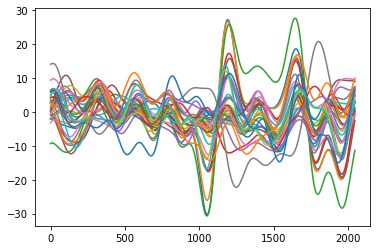

In [10]:
pl.plot(n_epoch[:,1,:].T)
pl.show()

### Question 2

In [231]:
# Target and Stimuli update after mask
target_m = target[mask]
stimuli_m = stim[mask]
# for i in range(len(target_m)):
#     print(f'{stimuli_m[i]} {target_m[i]}')
# Create new mask for target and non target values
mask_targ = (stimuli_m == target_m)
# count = 0
# for i in range(126,258):
#     print(target_m[i],stimuli_m[i],mask_targ[i])
#     if mask_targ[i] == True:
#         count += 1
# print(count)
# print(t_count[1])
mask_nontarg = (~mask_targ)
# Determine Target and Non target epochs
targ_epochs = n_epoch[:,mask_targ,:]
non_targ_epochs =n_epoch[:,mask_nontarg,:]

In [232]:
# Print size of epochs
print(non_targ_epochs.shape)
print(targ_epochs.shape)

(32, 2260, 2048)
(32, 398, 2048)


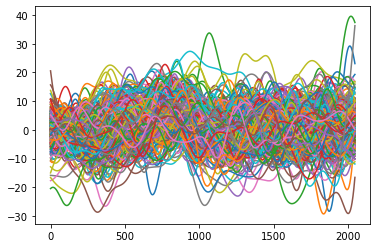

In [13]:
pl.plot(targ_epochs[0,:,:].T)
pl.show()

In [233]:
non_targ = np.mean(non_targ_epochs,axis=1)
targ = np.mean(targ_epochs,axis=1)
print(non_targ.shape)
print(targ.shape)

(32, 2048)
(32, 2048)


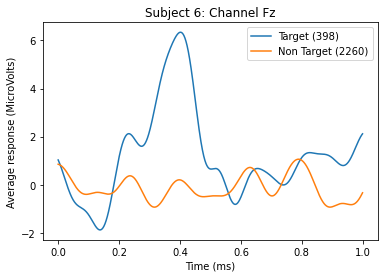

In [16]:
t = np.arange(0,1,1/2048)
pl.plot(t,targ[30])
pl.plot(t,non_targ[30])
pl.xlabel('Time (ms)')
pl.ylabel('Average response (MicroVolts)')
pl.title('Subject 6: Channel Fz')
pl.legend(['Target (398)','Non Target (2260)'])
pl.show()

5.422 |  1
5.614 |  2
5.443 |  3
6.313 |  4
6.139 |  5
5.773 |  6
4.900 |  7
5.588 |  8
5.429 |  9
4.602 |  10
4.468 |  12
4.702 |  13
4.369 |  19
4.342 |  21
5.525 |  22
5.716 |  23
4.201 |  24
5.537 |  25
6.344 |  26
6.023 |  27
5.383 |  28
5.686 |  29
5.498 |  30
6.146 |  31
6.140 |  32


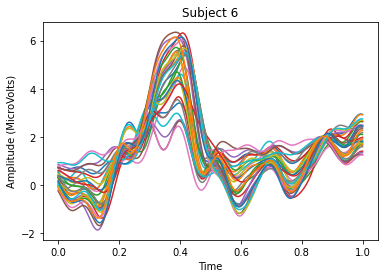

In [264]:
difference = targ - non_targ

for p in range(difference.shape[0]):
    pl.plot(t,difference[p,:])
    pl.xlabel('Time')
    pl.ylabel('Amplitude (MicroVolts)')
    pl.title(f'Subject 6')
    if max(difference[p,:]) >= 4:
        print(f'{max(difference[p,:]):.3f} |  {p+1}')
# fig, axs = plt.subplots(8, 4, sharey=True,figsize = (40,19))

# i=0
# for x in range(8):
#     for y in range(4):
#         axs[x,y].plot(difference[i,:])
#         axs[x,y].set_title(f'Difference Channel {i+1}')
#         i+=1
        # axs[x,y].set(xlabel = 'Time (seconds)', y_label ='Amplitude (uV)')


### Do you see a P300 response for subject 6? Which channels are worth keeping to discriminate against target and non target?
There is definitly a visible P300 response for subject 6, it can be seen as this large peak in the graph above. From chanPeaks we can see that the best channels worth keeping to discriminate against target and non target are those with the higher peak difference. These are:
1 = Fp1,
2 = AF3,
3 = F7,
4 = F3,
5 = FC1,
6 = FC5,
7 = T7,
8 = C3,
9 = CP1,
10 = CP5,
12 = P3,
13 = Pz,
19 = P4,
21 = CP6,
22 = CP2,
23 = C4,
24 = T8,
25 = FC6,
26 = FC2,
27 = F4,
28 = F8,
29 = AF4,
30 = Fp2,
31 = Fz,
32 = Cz

### Question 3


In [18]:
# Subject 2
path2 =['subject2/session1/','subject2/session2/','subject2/session3/','subject2/session4/']
mats2 = []
for session in path2:
    for file in os.listdir(session):
        mats2.append(glob.glob(session+file))

 # initialize epochs with the first session and first run
epoch_all2,target2,stim2,t_count2 = singletrial(sio.loadmat(mats2[0][0],squeeze_me = True))
print(epoch_all2.shape)
for i in range(1,len(mats2)):
    file_path2 = sio.loadmat(mats2[i][0],squeeze_me = True) # this will load the data file for each of the elements in the file
    epochtemp2, targettemp2, stimtemp2, t_counttemp2 = singletrial(file_path2)
    epoch_all2 = np.concatenate((epoch_all2,epochtemp2),1)
    target2 = np.append(target2,targettemp2,axis=0)
    stim2 = np.append(stim2,stimtemp2,axis=0)
    t_count2 = np.append(t_count2,t_counttemp2)
    
    print(epoch_all2.shape)
    
# Subtract baseline DC value from each trial
baseline_epochs2 = baseline(epoch_all2)
print(baseline_epochs2.shape)

# Reject noisy trials by checking if the data within that trial exceeds 40 microvolts (in both negative and positive in both directions)
mask2 = np.all(np.abs(baseline_epochs2).max(axis = 2)<40,axis=0)
# mask = np.all(maxdata, axis = 0)
n_epoch2 = baseline_epochs2[:,mask2,:]
print(n_epoch2.shape)

(32, 138, 2048)
(32, 270, 2048)
(32, 408, 2048)
(32, 540, 2048)
(32, 678, 2048)
(32, 804, 2048)
(32, 930, 2048)
(32, 1074, 2048)
(32, 1218, 2048)
(32, 1368, 2048)
(32, 1506, 2048)
(32, 1638, 2048)
(32, 1776, 2048)
(32, 1914, 2048)
(32, 2058, 2048)
(32, 2208, 2048)
(32, 2334, 2048)
(32, 2466, 2048)
(32, 2616, 2048)
(32, 2742, 2048)
(32, 2892, 2048)
(32, 3042, 2048)
(32, 3180, 2048)
(32, 3324, 2048)
(32, 3324, 2048)
(32, 2606, 2048)


target shape:  (32, 419, 2048)
non-target shape:  (32, 2187, 2048)
(32, 2048)
(32, 2048)


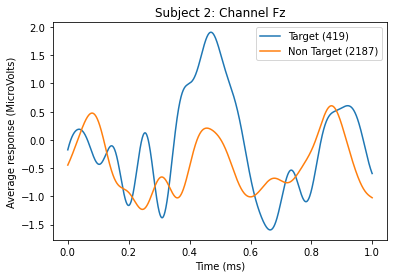

In [19]:
# Target and Stimuli update after mask
target_m2 = target2[mask2]
stimuli_m2 = stim2[mask2]

# Create new mask for target and non target values
mask_targ2 = (stimuli_m2 == target_m2)
mask_nontarg2 = (~mask_targ2)

# Determine Target and Non target epochs
targ_epochs2 = n_epoch2[:,mask_targ2,:]
non_targ_epochs2 =n_epoch2[:,mask_nontarg2,:]
print('target shape: ',targ_epochs2.shape)
print('non-target shape: ',non_targ_epochs2.shape)
# Take the average along the trials for each electrode
non_targ2 = np.mean(non_targ_epochs2,axis=1)
targ2 = np.mean(targ_epochs2,axis=1)
print(non_targ2.shape)
print(targ2.shape)

# Plot the Fz channel's average response both target and non target
t = np.arange(0,1,1/2048)
pl.plot(t,targ2[30])
pl.plot(t,non_targ2[30])
pl.xlabel('Time (ms)')
pl.ylabel('Average response (MicroVolts)')
pl.title('Subject 2: Channel Fz')
pl.legend(['Target (419)','Non Target (2187)'])
pl.show()

(32, 2048)


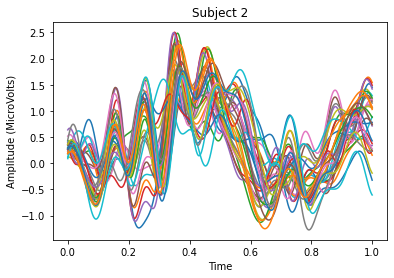

In [20]:
# Plot the difference between the target and non target repsonses in all channels
difference2 = targ2 - non_targ2
print(difference2.shape)
for p in range(difference2.shape[0]):
    pl.plot(t,difference2[p,:])
    pl.xlabel('Time')
    pl.ylabel('Amplitude (MicroVolts)')
    pl.title(f'Subject 2')

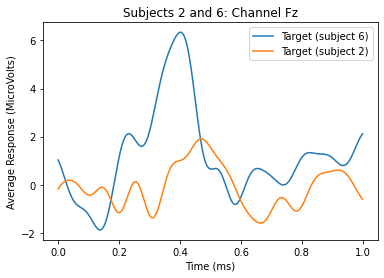

In [21]:
# Plot channel Fz for both patients and comment on similarities across both and what this means for the BCI 
pl.plot(t,targ[30])
pl.plot(t,targ2[30])
pl.xlabel('Time (ms)')
pl.ylabel('Average Response (MicroVolts)')
pl.title('Subjects 2 and 6: Channel Fz')
pl.legend(['Target (subject 6)','Target (subject 2)'])
pl.show()

### Comment on how similar or not the results are across Subject 6 and the patient you chose, and what this means for your BCI application.
We can see here that there is a clear P300 response for subject 6, whereas subject 2 does not have said response, this could be due to the subjects multiplesclerosis or the subjects mild nystagmus voluntary eye movement. This means that the BCI application will need to be trained differently for each patient.

## Part B - Extracting Time Window with Statistical Analysis
### Question 1  - Permutations on Subject 6 Channel Fz

In [22]:
# Permutation
def permtest(x1, x2, Nperms):
    N1 = x1.shape[0]
    #print(N1)
    N2 = x2.shape[0]
    #print(N2)
    perms = np.zeros((Nperms,x1.shape[1]))
    bucket = np.concatenate((x1, x2),axis=0)
    #print(bucket.shape)
    for k in range(Nperms):
        x = np.random.permutation(bucket)
        x1perm = x[:N1]
        x2perm = x[N1:]
        perms[k,:] = np.mean(x1perm,axis=0) - np.mean(x2perm,axis=0)
    actual = np.mean(x1, axis=0)- np.mean(x2, axis=0)
   # print(actual.shape)
    p = np.float64((perms.max()> actual.max()).sum()) / Nperms
    return perms,actual,p 

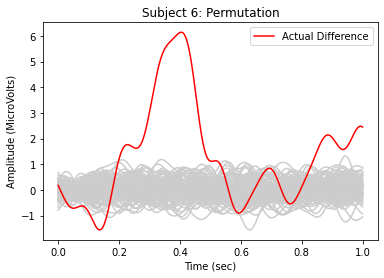

Expected p-value: 0.0


In [23]:
# Use subject 6 as standard
perms,actual,p = permtest(targ_epochs[30,:,:],non_targ_epochs[30,:,:],100)
t = np.arange(0,1,1/2048)
# print(perms.shape)
for i in range(perms.shape[0]):
    pl.plot(t,perms[i,:],'0.8')
pl.plot(t,actual, 'red', label = 'Actual Difference')
pl.title('Subject 6: Permutation')
pl.xlabel('Time (sec)')
pl.ylabel('Amplitude (MicroVolts)')
pl.legend()
pl.show()
print(f'Expected p-value: {p}')

 The best continuous time window where the actual difference differs from the null examples is between 0.250 and 0.450 seconds.
 ### Question 2/3 - P Values of channels Fz, Cz, Pz, and Oz

Expected p-value for 1000 null examples in channel Fz: 0.0000


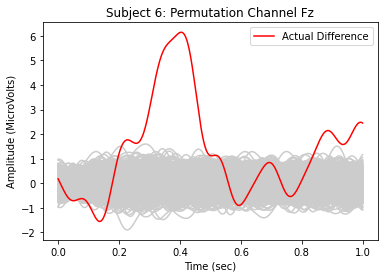

In [24]:
perms_1,actual_1,p_1 = permtest(targ_epochs[30,:,:],non_targ_epochs[30,:,:],1000)
print(f'Expected p-value for 1000 null examples in channel Fz: {p_1:.4f}')
for i in range(perms_1.shape[0]):
    pl.plot(t,perms_1[i,:],'0.8')
pl.plot(t,actual_1, 'red', label = 'Actual Difference')
pl.title('Subject 6: Permutation Channel Fz')
pl.xlabel('Time (sec)')
pl.ylabel('Amplitude (MicroVolts)')
pl.legend()
pl.show()

 ### What is the P-Value for Channel Fz for Subject 6:
 The p-value with 1000 null examples is 0.000, meaning we can reject the null hypothesis that the difference between target and non-target is null.

Expected p-value for 1000 null examples in channel Cz: 0.0000


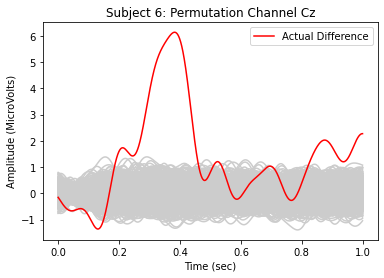

In [25]:
perms_Cz,actual_Cz,p_Cz = permtest(targ_epochs[31,:,:],non_targ_epochs[31,:,:],1000)
print(f'Expected p-value for 1000 null examples in channel Cz: {p_Cz:.4f}')
for i in range(perms_Cz.shape[0]):
    pl.plot(t,perms_Cz[i,:],'0.8')
pl.plot(t,actual_Cz, 'red', label = 'Actual Difference')
pl.title('Subject 6: Permutation Channel Cz')
pl.xlabel('Time (sec)')
pl.ylabel('Amplitude (MicroVolts)')
pl.legend()
pl.show()

Expected p-value for 1000 null examples in channel Pz: 0.0000


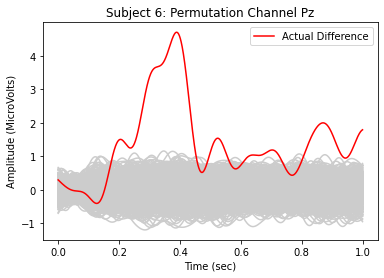

In [26]:
perms_Pz,actual_Pz,p_Pz = permtest(targ_epochs[12,:,:],non_targ_epochs[12,:,:],1000)
print(f'Expected p-value for 1000 null examples in channel Pz: {p_Pz:.4f}')
for i in range(perms_Pz.shape[0]):
    pl.plot(t,perms_Pz[i,:],'0.8')
pl.plot(t,actual_Pz, 'red', label = 'Actual Difference')
pl.title('Subject 6: Permutation Channel Pz')
pl.xlabel('Time (sec)')
pl.ylabel('Amplitude (MicroVolts)')
pl.legend()
pl.show()

Expected p-value for 1000 null examples in channel Oz: 0.0000


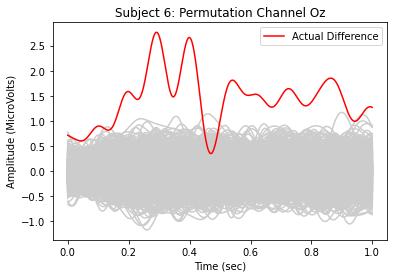

In [27]:
perms_Oz,actual_Oz,p_Oz = permtest(targ_epochs[15,:,:],non_targ_epochs[15,:,:],1000)
print(f'Expected p-value for 1000 null examples in channel Oz: {p_Oz:.4f}')
for i in range(perms_Oz.shape[0]):
    pl.plot(t,perms_Oz[i,:],'0.8')
pl.plot(t,actual_Oz, 'red', label = 'Actual Difference')
pl.title('Subject 6: Permutation Channel Oz')
pl.xlabel('Time (sec)')
pl.ylabel('Amplitude (MicroVolts)')
pl.legend()
pl.show()

The respective P-Values for channels Cz, Pz, and Oz are all <0.001.
There are different time segments between these channels that standout, they are as follows:

Fz between 250 and 450 ms 

Cz between 300 and 450 ms

Pz between 300 and 400 ms

Oz between 200 and 400 ms and 550 and 850 ms

## Part C - Research considerations, and evaluating BCI potential
### Question 1 -  Permutations per session (N/4) or per file (N/24)

Expected p-value for 1000 null examples in channel Fz: 0.0000


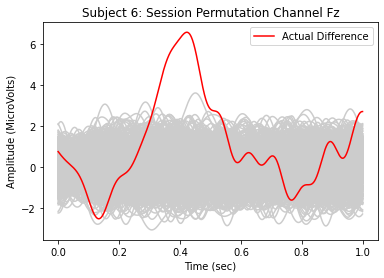

In [28]:
# Get the first 1/4 of the target and non-target epochs of channel Fz to simulate session
s_t = int(targ_epochs.shape[1]/4)
s_n = int(non_targ_epochs.shape[1]/4)
targ_sess = targ_epochs[30,0:s_t,:]
non_targ_sess = non_targ_epochs[30,0:s_n,:]

# Print and plot 
perms_Fz,actual_Fz,p_Fz = permtest(targ_sess,non_targ_sess,1000)
print(f'Expected p-value for 1000 null examples in channel Fz: {p_Fz:.4f}')
for i in range(perms_Fz.shape[0]):
    pl.plot(t,perms_Fz[i,:],'0.8')
pl.plot(t,actual_Fz, 'red', label = 'Actual Difference')
pl.title('Subject 6: Session Permutation Channel Fz')
pl.xlabel('Time (sec)')
pl.ylabel('Amplitude (MicroVolts)')
pl.legend()
pl.show()

Expected p-value for 1000 null examples in channel Fz: 0.0010


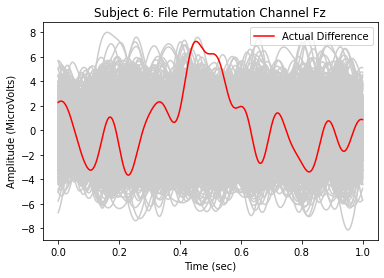

In [29]:
# Get the first 1/24 of the target and non-target epochs of channel Fz to simulate file
file_t = int(targ_epochs.shape[1]/24)
file_n = int(non_targ_epochs.shape[1]/24)
targ_file = targ_epochs[30,0:file_t,:]
non_targ_file = non_targ_epochs[30,0:file_n,:]

# Print and plot 
perms_Fz,actual_Fz,p_Fz = permtest(targ_file,non_targ_file,1000)
print(f'Expected p-value for 1000 null examples in channel Fz: {p_Fz:.4f}')
for i in range(perms_Fz.shape[0]):
    pl.plot(t,perms_Fz[i,:],'0.8')
pl.plot(t,actual_Fz, 'red', label = 'Actual Difference')
pl.title('Subject 6: File Permutation Channel Fz')
pl.xlabel('Time (sec)')
pl.ylabel('Amplitude (MicroVolts)')
pl.legend(loc="upper right")
pl.show()

#### Comment on the significance of these p-values for session and file for the BCI:
The significance of these p-values per electrode per session and file is to see what precision the BCI needs to reject the null hypothesis. With one electrode, it seems the BCI is able to reject the null hypothesis per session, that the actual difference between non-target and target epochs is not different than the null examples of differences. In other words, when analysing the data per session we are able to differ Target from Non-Target, but when analysing per file we are unable.

### Question 2 - How consistent are these results across files?

In [30]:
# Get the first 1/24 of the target and non-target epochs of channel Fz to simulate file
file_t = int(targ_epochs.shape[1]/24)
file_n = int(non_targ_epochs.shape[1]/24)

x=0
y=0
for k in range(24):
    targ_files = targ_epochs[30,x:x + file_t,:]
    non_targ_files = non_targ_epochs[30,y:y+file_n,:]
    perms_Fz,actual_Fz,p_Fz = permtest(targ_files,non_targ_files,1000)
    print(f'Expected p-value for 1000 null examples in channel Fz file {k+1}: {p_Fz:.4f}')
#     for i in range(perms_Fz.shape[0]):
#         pl.plot(t,perms_Fz[i,:],'0.8')
#     pl.plot(t,actual_Fz, 'red', label = 'Actual Difference')
#     pl.title(f'Subject 6: File {k+1} Permutation Channel Fz')
#     pl.xlabel('Time (sec)')
#     pl.ylabel('Amplitude (MicroVolts)')
#     pl.legend(loc = "upper right")
#     pl.show()
    x+=file_t
    y+=file_n

Expected p-value for 1000 null examples in channel Fz file 1: 0.0010
Expected p-value for 1000 null examples in channel Fz file 2: 0.0010
Expected p-value for 1000 null examples in channel Fz file 3: 0.0010
Expected p-value for 1000 null examples in channel Fz file 4: 0.0000
Expected p-value for 1000 null examples in channel Fz file 5: 0.0010
Expected p-value for 1000 null examples in channel Fz file 6: 0.0010
Expected p-value for 1000 null examples in channel Fz file 7: 0.0000
Expected p-value for 1000 null examples in channel Fz file 8: 0.0010
Expected p-value for 1000 null examples in channel Fz file 9: 0.0000
Expected p-value for 1000 null examples in channel Fz file 10: 0.0010
Expected p-value for 1000 null examples in channel Fz file 11: 0.0010
Expected p-value for 1000 null examples in channel Fz file 12: 0.0010
Expected p-value for 1000 null examples in channel Fz file 13: 0.0010
Expected p-value for 1000 null examples in channel Fz file 14: 0.0010
Expected p-value for 1000 nul

### Comment on the significance of these observations for the real-world performance of the BCI.
These results are inconsistent across files as can be seen above. This indicates that the BCI is able to differ Target from Non-Targt in a single electrode in a single file less than half of the time. Which can lead us to conclude to things: either the BCI requires more electrodes, or more files to accurately classify a target. 

In the real-world the performance of the BCI should not take too long to process and determine what the target is. If we were able to differentiate actual difference from null examples in all files, then it would be reasonable to say that we would need far less files to determine target images. We see however that the accuracy per electrode per file is low, we would still need the full session to train the BCI.

### Question 3 - Apply the same analyses on at least one patient (choose arbitrarily; the paper gives you list of which subject numbers are controls and which are patients). 

In [31]:
## Choose subject 2
# Get the first 1/24 of the target and non-target epochs of channel Fz to simulate file
file_t = int(targ_epochs2.shape[1]/24)
file_n = int(non_targ_epochs2.shape[1]/24)

x=0
y=0
for k in range(24):
    targ_files = targ_epochs2[30,x:x + file_t,:]
    non_targ_files = non_targ_epochs2[30,y:y+file_n,:]
    perms_Fz,actual_Fz,p_Fz = permtest(targ_files,non_targ_files,1000)
    print(f'Expected p-value for 1000 null examples in channel Fz file {k+1}: {p_Fz:.4f}')
    x+=file_t
    y+=file_n


Expected p-value for 1000 null examples in channel Fz file 1: 0.0010
Expected p-value for 1000 null examples in channel Fz file 2: 0.0010
Expected p-value for 1000 null examples in channel Fz file 3: 0.0010
Expected p-value for 1000 null examples in channel Fz file 4: 0.0010
Expected p-value for 1000 null examples in channel Fz file 5: 0.0010
Expected p-value for 1000 null examples in channel Fz file 6: 0.0010
Expected p-value for 1000 null examples in channel Fz file 7: 0.0010
Expected p-value for 1000 null examples in channel Fz file 8: 0.0010
Expected p-value for 1000 null examples in channel Fz file 9: 0.0010
Expected p-value for 1000 null examples in channel Fz file 10: 0.0010
Expected p-value for 1000 null examples in channel Fz file 11: 0.0010
Expected p-value for 1000 null examples in channel Fz file 12: 0.0010
Expected p-value for 1000 null examples in channel Fz file 13: 0.0010
Expected p-value for 1000 null examples in channel Fz file 14: 0.0010
Expected p-value for 1000 nul

### Based on your results, comment on how well you expect to perform for the patient if you "trained" your BCI using one file (i.e., 1/24th of the data) and "tested" it on the data from other files. Also comment on how your results for the patient’s data compare to that of subject #6 (which is a control subject).
We would expect the BCI to perform poorly in a subject other than a control, due to its performance with the control. 
From Subject 2, we see that there is no rejection of the p-value throughout the entire session. This means that if we were to use a single file as training for the BCI, we would see very low accuracy with our BCI in other files.
The control subject had some rejection of the null hypothesis when we used one file (1/24th of the data) to determine p-values, which leads us to believe that there could maybe be a possibility of using this as a training file for other files.



### Question 4 - Now let’s try to get a sense of what the BCI performance will be by designing a simple BCI by manual classification. Start with subject 6’s data again but keeping channels Fz, Cz, Pz and Oz.

In [268]:
## Subject 6 Target and Non target epochs for channels Fz, Cz, Pz, and Oz (31, 32, 13, and 16)
# All 4 target epochs for each channel of interest
targ_sub6 = targs = targ_epochs[30,:,:]
targ_sub6 = np.append(targ_sub6, targ_epochs[31,:,:],axis=1)
targ_sub6 = np.append(targ_sub6, targ_epochs[12,:,:],axis=1)
targ_sub6 = np.append(targ_sub6, targ_epochs[15,:,:],axis=1)
print(targ_sub6.shape)
# All 4 non-target epochs for eacg channel of interest
non_targ_sub6 =non_targ_epochs[30,:,:]
non_targ_sub6 = np.append(non_targ_sub6, non_targ_epochs[31,:,:],axis=1)
non_targ_sub6 = np.append(non_targ_sub6, non_targ_epochs[12,:,:],axis=1)
non_targ_sub6 = np.append(non_targ_sub6, non_targ_epochs[15,:,:],axis=1)
print(non_targ_sub6.shape)
data_all = np.append(targ_sub6,non_targ_sub6, axis = 0)
print(data_all.shape)

(398, 8192)
(2260, 8192)
(2658, 8192)


In [81]:
def pca_extract(dim,data):
    # PCA to get 2 dimensions
    from sklearn.decomposition import PCA
    # Create a model
    pc = PCA(n_components=dim) 
    # Fit to data
    pc.fit(data) 
    # Extract 2 PCs
    data_pc = pc.transform(data)
    
    return data_pc

In [104]:
# # PrincipalComponent analysis of target with non target
pc_data = pca_extract(2,data_all.T)
# Project the target and non target data onto the principal components
a1 = np.dot(targ_sub6,pc_data[:,0])
a2 = np.dot(targ_sub6,pc_data[:,1])
b1 = np.dot(non_targ_sub6,pc_data[:,0])
b2 = np.dot(non_targ_sub6,pc_data[:,1])

### Describe the process of going from 8192 dimensions to 2 dimensions. This is called feature extraction.
To go from 8192 features to 2 I used 2 dimensional PCA. PCA is a method commonly used to extract principal components in data that adequatly summarize the relationship between the data. Commonly, a matrix of covariance is made, and eigenvectors are drawn from this. The last eigenvectors store the most information regarding the data, and therefore are used as PCs. In this case, I used a PCA function to do this portion for me. 
After using the PCA function I then projected the data onto both of the principal components that were extracted. This allows me to plot the data in a 2D plot and visualize the relationship of the data with both PCs. 

## Question 5 -  Plot the extracted features in 2D

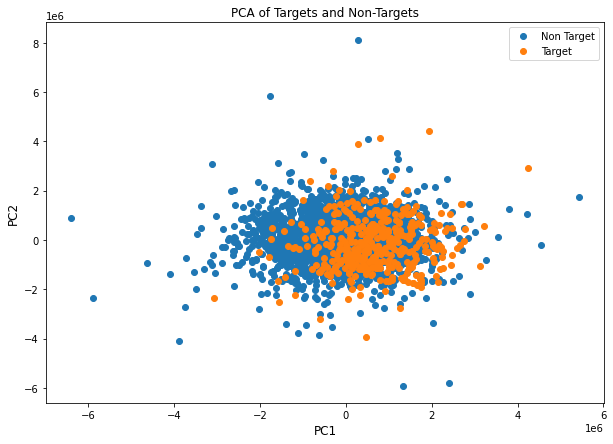

In [95]:
# Plot the PC valuesfor target and non target next to all data  using the 2 new dimensions as axis
pl.figure(figsize = (10,7))
pl.plot(b1,b2,marker ='o',linestyle='none', label = 'Non Target')
pl.plot(a1,a2,marker ='o',linestyle='none', label = 'Target')
pl.title('PCA of Targets and Non-Targets')
pl.xlabel('PC1',fontsize=12)
pl.ylabel('PC2',fontsize=12)
pl.legend()
pl.show()

### Are you able to manually design a classifier by choosing some boundaries (similar to how you did it with spike sorting in PS2) between the two clusters?
I am not able to manually classify each cluster since there is complete overlay. If I were to define boundaries I would incorrectly label target and non-target data.
If I hadn't already labeled and classified each data point it would present as one single cluster, which makes it extremely difficult to classify targets and non targets.
### Repeat the plotting now with K=10 epochs averaged together, i.e., instead of classifying the (aproaximately) N = 2500, M=250 single trials, you should average trials 1:10, 11:20, 21:30, ... for non-target and target separately, and be left with (N/K) = 250 non-target averages and (M/K) = 25 target averages. 

In [267]:
def k_avg(K,targ_epochs,non_targ_epochs):
    N = targ_epochs.shape[0]
    M = non_targ_epochs.shape[0]
    av_targ = np.zeros((int(N/K),targ_epochs.shape[1]))
    av_non_targ = np.zeros((int(M/K),non_targ_epochs.shape[1]))
    x = 0
    y = 0
    for i in range(int(N/K)):
        # average of every K target epochs
        av_targ[i,:] = np.mean(targ_epochs[x:x+K-1,:],axis=0)
        x += K 
    for j in range(int(M/K)):
        # average of every K non target epochs
        av_non_targ[j,:] = np.mean(non_targ_epochs[y:y+K-1,:],axis=0)
        y += K
        
    #print(f'The shape of averaging of every {K} Target: {av_targ.shape} and Non Target:{av_non_targ.shape}epoch')
    return av_targ,av_non_targ

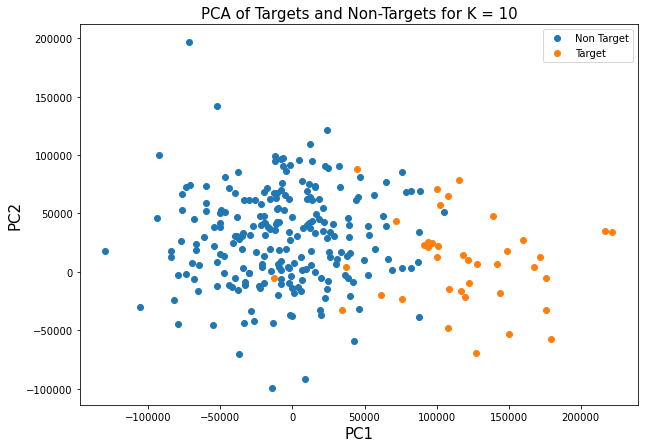

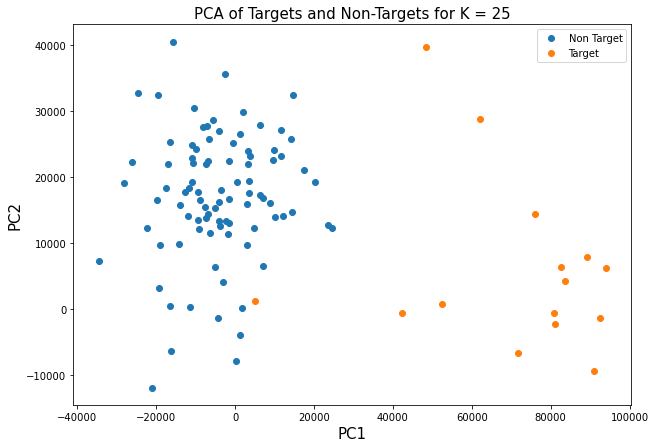

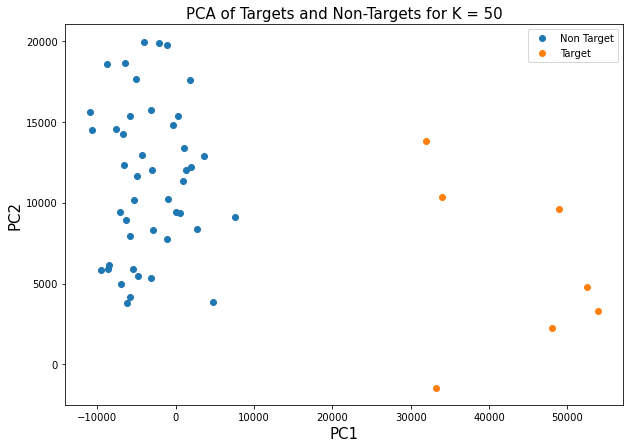

In [101]:
k_list = [10,25,50]
for i in k_list:
#     print(i)
    # Take the average of every K trials
    targ,nontarg = k_avg(i,targ_sub6,non_targ_sub6)
    dataAll = np.append(targ,nontarg,axis=0)
    # PCA these averages
    pcall = pca_extract(2,dataAll.T)
    # Project the target and non target data onto the principal components
    a1 = np.dot(targ,pcall[:,0])
    a2 = np.dot(targ,pcall[:,1])
    b1 = np.dot(nontarg,pcall[:,0])
    b2 = np.dot(nontarg,pcall[:,1])
    # Plot Target and Non Target Values onto the PCs
    pl.figure(figsize = (10,7))
    pl.plot(b1,b2,marker ='o',linestyle='none', label = 'Non Target')
    pl.plot(a1,a2,marker ='o',linestyle='none', label = 'Target')
    pl.title(f'PCA of Targets and Non-Targets for K = {i}',fontsize=15)
    pl.xlabel('PC1',fontsize=15)
    pl.ylabel('PC2',fontsize=15)
    pl.legend()
    pl.show()


### Are you able to now draw a boundary? Explain what you see for K=10, 25, and 50
With K = 10, I am now able to draw a boundary. I would still have difficulties classifying all data points as there is some overlay. In general the data does not present itself as two separate clusters which makes it difficult to differentiate and classsify. When classifying I will have to pick between specificity or sensitivity. 
As K gets larger, the files get smaller (as we average K files into one). The plot of all three clearly depicts this reduction in data points across the two principal components. 
## Question 6 - Let’s say that the null hypothesis (H0) for the classifier is that a given trial is a "non-target" trial, and the alternate (H1) being that it is a “target” trial. When drawing broundaries between clusters, you can choose your boundaries to have more false alarms and fewer misses, or the other way around. Which way would you prefer and why? 
When choosing my boundaries in this case I would prioritize having less false alarms and more misses, because this BCI is determining which appliance to turn on, it would be very frusturating to have the TV turn on when trying to get the lamp to turn on, or opening the door when you wanted to watch TV. If the patient has a child or pet these are all instances in which turning on the wrong appliance would cause greater pain than just not turning anything on. Although it might take longer to turn on the lamp due to the larger miss rate, I would rather know that the appliance I want will turn on and not some other ampliance in it's place. Overall, in my BCI I would prioritize specificity over sensitivity. 

### For the K=10 case from subpart 5, obtain and plot a rough ROC curve for target detection by choosing 8 different boundaries spanning a range of sensitivities and specificities. This ROC curve is a nice summary of the BCI performance for K=10. In terms of the real-world application of this BCI, what are some other ways in which you would want to evaluate its performance?

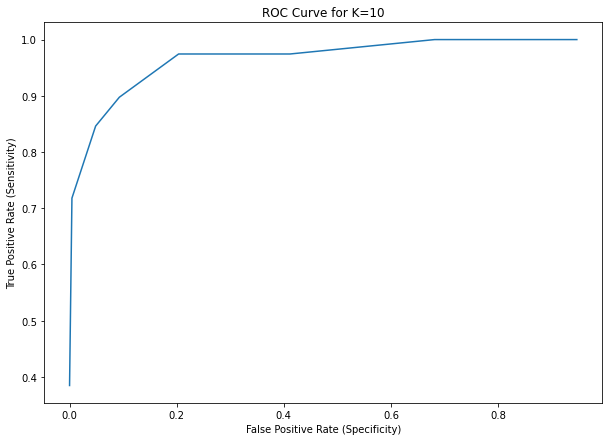

In [269]:
# Take the average of every K trials
targ,nontarg = k_avg(10,targ_sub6,non_targ_sub6)
dataAll = np.append(targ,nontarg,axis=0)
# PCA these averages
pcall = pca_extract(2,dataAll.T)
# Project the target and non target data onto the principal components
a1 = np.dot(targ,pcall[:,0])
b1 = np.dot(nontarg,pcall[:,0])
# Create 8 boundaries over PC1 for both target and nontarget
# Counts all non target values inside the bounds
b_1 = (b1 >= 125000)
b_2 = (b1 >= 100000)
b_3 = (b1 >= 75000) 
b_4 = (b1 >= 50000)
b_5 = (b1 >= 25000) 
b_6 = (b1 >= 0)
b_7 = (b1 >= -25000)
b_8 = (b1 >= -75000)
# Counts all Targets inside the bounds
bound1 = (a1 >= 125000)
bound2 = (a1 >= 100000)
bound3 = (a1 >= 75000) 
bound4 = (a1 >= 50000)
bound5 = (a1 >= 25000) 
bound6 = (a1 >= 0)
bound7 = (a1 >= -25000)
bound8 = (a1 >= -75000)


TPR = np.count_nonzero(a1[bound1])
TPR = np.append(TPR,np.count_nonzero(a1[bound2]))
TPR = np.append(TPR,np.count_nonzero(a1[bound3]))
TPR = np.append(TPR,np.count_nonzero(a1[bound4]))
TPR = np.append(TPR,np.count_nonzero(a1[bound5]))
TPR = np.append(TPR,np.count_nonzero(a1[bound6]))
TPR = np.append(TPR,np.count_nonzero(a1[bound7]))
TPR = np.append(TPR,np.count_nonzero(a1[bound8]))
TPR = TPR / a1.shape[0]
# FPR = 1 - TPR

FPR = np.count_nonzero(b1[b_1])
FPR = np.append(FPR,np.count_nonzero(b1[b_2]))
FPR = np.append(FPR,np.count_nonzero(b1[b_3]))
FPR = np.append(FPR,np.count_nonzero(b1[b_4]))
FPR = np.append(FPR,np.count_nonzero(b1[b_5]))
FPR = np.append(FPR,np.count_nonzero(b1[b_6]))
FPR = np.append(FPR,np.count_nonzero(b1[b_7]))
FPR = np.append(FPR,np.count_nonzero(b1[b_8]))
FPR = FPR / b1.shape[0]
pl.figure(figsize = (10,7))
pl.plot(FPR,TPR)
pl.xlabel("False Positive Rate (Specificity)")
pl.ylabel("True Positive Rate (Sensitivity)")
pl.title("ROC Curve for K=10")
pl.show()

This ROC curve shows us at what boundary our level of specificty is prioritized over our level of sensitivity and vice versa. This a great way to determine how sensitive or specific a BCI is, but we would also need to evaluate performance with regards to other elements. Specifically in the case of BCIs, time is of the essence. It would be crucial for the program to run and determine with a high level of specificity what is a target image and what is not within a short period of time. 